<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_252.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 
#### For Watershed 252, this model's sMAPE score is: 140.72380630027757

In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [3]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/drive/MyDrive/Kalman_Filter/top_ten_watersheds.csv /content/

In [4]:
df = pd.read_csv('top_ten_watersheds.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,175,0.966122,-21.574120,-27.607310,NaN
1,1950-01-02,175,1.008771,-25.995184,-31.368013,NaN
2,1950-01-03,175,0.000000,-28.295700,-38.181858,NaN
3,1950-01-04,175,0.000000,-26.836973,-39.946175,NaN
4,1950-01-05,175,0.000000,-29.592003,-37.728634,NaN


In [5]:
df.watershed.unique()

array([175,   8, 205, 159, 252, 110, 214,  27, 147, 236])

### Phase Two: Data Cleaning and Feature Selection

In [6]:
# As watershed 8 had the second most discharge values, it will be explored. 
shed252 = df[(df['watershed'] == 252)]
shed252.tail()

,time,watershed,pr,tasmax,tasmin,discharge
126005,2018-12-27,252,2.922923,-12.856770,-18.413538,NaN
126006,2018-12-28,252,0.500000,-16.873077,-24.970000,NaN
126007,2018-12-29,252,0.000000,-10.372923,-23.417461,NaN
126008,2018-12-30,252,0.182308,-9.655461,-20.490616,NaN
126009,2018-12-31,252,2.500000,-15.275847,-28.205769,NaN


In [7]:
# It seems watershed 8 has null values towards the end of its readings. 
# Observe when the last recorded discharge value was. 
copy = shed252.copy()
copy.dropna(inplace=True)
copy.tail()

,time,watershed,pr,tasmax,tasmin,discharge
125640,2017-12-27,252,0.000000,-22.172308,-32.622307,0.0
125641,2017-12-28,252,0.709846,-18.725769,-28.303923,0.0
125642,2017-12-29,252,0.172308,-23.282540,-31.700000,0.0
125643,2017-12-30,252,0.000000,-27.654154,-35.085155,0.0
125644,2017-12-31,252,0.000000,-23.956770,-32.147152,0.0


In [8]:
# For ease of multi-watershed experimentation, a copy is made. 
model = shed252.copy()

In [9]:
# We will be focusing on the past twentyfive years of data. 
# As 2016 was the last year of recordings, 1992 forward will be taken. 
model = model[(model['time'] > '1992-12-31') & (model['time'] < '2018-01-01')]

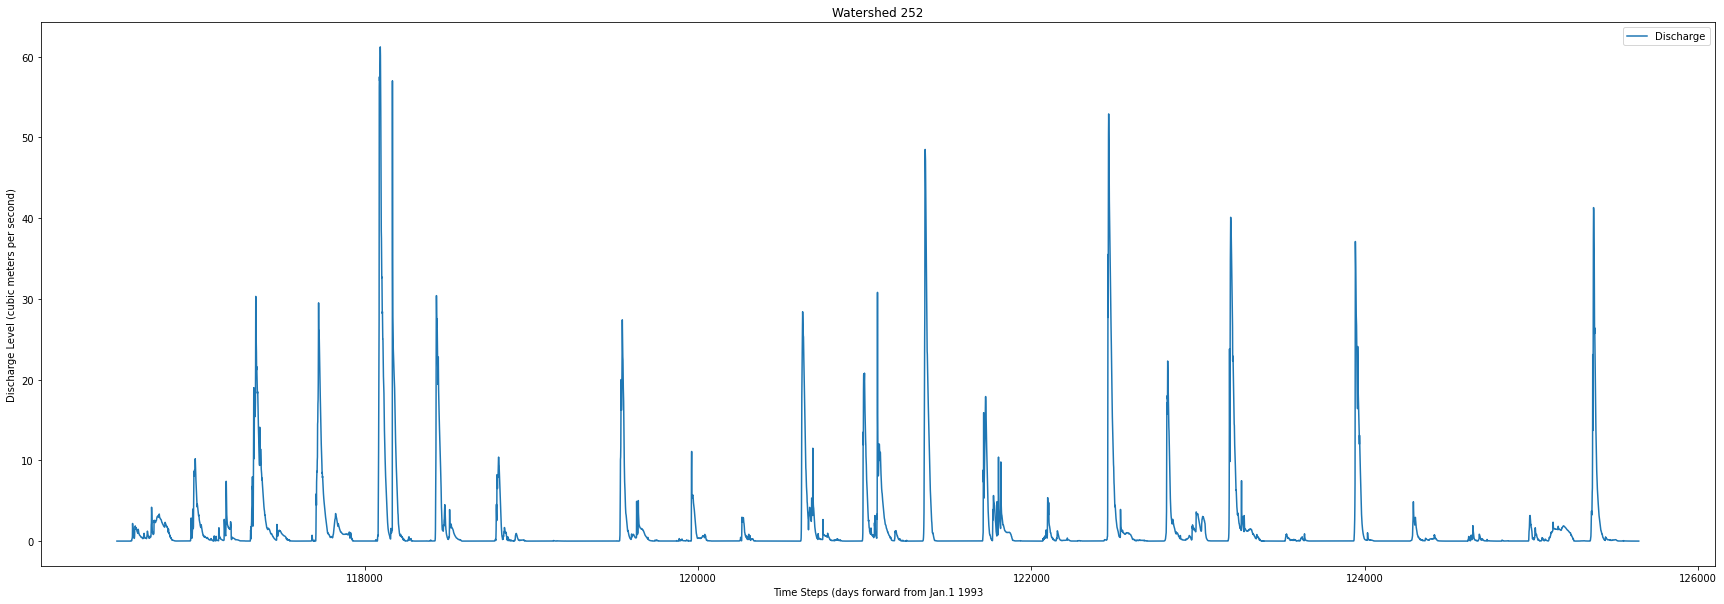

In [10]:
# For visual representation, plotting discharge of watershed 205
x = range(len(model))
y = model.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 252")
plt.xlabel("Time Steps (days forward from Jan.1 1993")
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [11]:
# There doesn't appear to be many missing discharge values. 
# Measure how many NaN's there are. 
model.isna().sum()

time         0
watershed    0
pr           0
tasmax       0
tasmin       0
discharge    0
dtype: int64

In [12]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
model["time"] = pd.to_datetime(model["time"])

In [13]:
model.set_index('time', inplace = True)
"""
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")
  """

'\nfor watershedID in set(shed205["watershed"]):\n  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method=\'time\', axis=0, limit_direction="both")\n  '

In [14]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model[name] = num_list #model1['discharge'][num]

In [15]:
# The target forecast was identified as 10 days, by a NRCan representative. 
advance(10)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10
time,,,,,,
1993-01-01,252,0.000,-18.833769,-34.715923,0.0,0.0
1993-01-02,252,0.000,-11.439462,-26.236000,0.0,0.0
1993-01-03,252,0.794,-14.446231,-23.397078,0.0,0.0
1993-01-04,252,0.000,-17.465538,-27.161077,0.0,0.0
1993-01-05,252,0.000,-17.128386,-24.785923,0.0,0.0


In [16]:
# Next a column representing the past week's cumulative rainfall. 

def rainfall(x):
  rainfall = []
  length = len(model.discharge)
  for i in range(length):
    # In this case, we're only interested in the past rainfall. 
    if i + x < 0:
      answer = model.pr[:i+1].sum()
    else:
      num = i + x
      answer = model.pr[num:i].sum()
    rainfall.append(answer)
  name = f"pr_{x}"
  model[name] = rainfall
  

In [17]:
rainfall(-7)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10,pr_-7
time,,,,,,,
1993-01-01,252,0.000,-18.833769,-34.715923,0.0,0.0,0.000
1993-01-02,252,0.000,-11.439462,-26.236000,0.0,0.0,0.000
1993-01-03,252,0.794,-14.446231,-23.397078,0.0,0.0,0.794
1993-01-04,252,0.000,-17.465538,-27.161077,0.0,0.0,0.794
1993-01-05,252,0.000,-17.128386,-24.785923,0.0,0.0,0.794


In [18]:
# For the purposes of this iteration of the model, only precipitation and discharge values will be kept. 
model = model.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase Three: Building the Multivariate Time Series Model


In [19]:
time_shift = 10

target_data = model['discharge'].shift(time_shift)
data = model.iloc[:-time_shift]
data

,pr,discharge,discharge_10,pr_-7
time,,,,
1993-01-01,0.000000,0.0,0.0,0.000000
1993-01-02,0.000000,0.0,0.0,0.000000
1993-01-03,0.794000,0.0,0.0,0.794000
1993-01-04,0.000000,0.0,0.0,0.794000
1993-01-05,0.000000,0.0,0.0,0.794000
...,...,...,...,...
2017-12-17,0.000000,0.0,0.0,6.452846
2017-12-18,0.339231,0.0,0.0,4.126462
2017-12-19,0.000000,0.0,0.0,3.455077


In [20]:
test_head = data.index[int(0.75*len(data))]
test_head

Timestamp('2011-09-24 00:00:00')

In [21]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [22]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [23]:
i = 27
sequence_length = 10
features = ['pr', 'discharge', 'pr_-7']
target = 'discharge_10'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[0.0000, 0.0000, 7.0732],
        [0.0000, 0.0000, 2.4248],
        [0.0000, 0.0000, 0.6388],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.8986, 0.0000, 0.0000],
        [0.0951, 0.0000, 0.8986]])


In [24]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 10, 3])
tensor([[[0.0000, 1.8500, 0.0000],
         [0.0000, 1.8500, 0.0000],
         [0.0000, 1.8100, 0.0000],
         [0.0000, 1.7700, 0.0000],
         [0.0000, 1.7700, 0.0000],
         [0.0000, 1.7300, 0.0000],
         [0.0000, 1.7400, 0.0000],
         [1.1954, 2.1700, 0.0000],
         [0.4754, 2.3200, 1.1954],
         [0.0000, 2.2700, 1.6708]],

        [[0.0000, 0.0000, 7.0435],
         [0.0000, 0.0000, 5.9677],
         [0.0000, 0.0000, 5.1165],
         [0.2438, 0.0000, 2.8391],
         [0.0000, 0.0000, 2.8768],
         [0.0000, 0.0000, 0.9253],
         [0.0000, 0.0000, 0.2438],
         [0.0000, 0.0000, 0.2438],
         [0.0000, 0.0000, 0.2438],
         [2.9885, 0.0000, 0.2438]],

        [[0.6928, 0.0000, 1.2908],
         [0.2695, 0.0000, 1.9836],
         [0.0000, 0.0000, 1.0577],
         [0.0000, 0.0000, 0.9626],
         [1.1954, 0.0000, 0.9626],
         [0.0000, 0.0000, 2.1580],
         [0.0000, 0.0000, 2.1580],
         [0.0000, 0.0000, 2.

In [25]:
batch_size = 4
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 10, 3])
Target shape: torch.Size([4])


In [26]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [39]:
learning_rate = 5e-5
num_hidden_units = 128

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 14.231497580906796

Epoch 0
---------
Train loss: 31.86262854274179
Test loss: 12.720354626635366

Epoch 1
---------
Train loss: 28.08249894286599
Test loss: 11.36726008908682

Epoch 2
---------
Train loss: 25.855352451814714
Test loss: 10.65249736361359

Epoch 3
---------
Train loss: 24.361852142321897
Test loss: 10.185260625419104

Epoch 4
---------
Train loss: 23.187605386111105
Test loss: 9.80635420399377

Epoch 5
---------
Train loss: 22.237236522956767
Test loss: 9.353118441674383

Epoch 6
---------
Train loss: 21.462985169680266
Test loss: 9.245890737670244

Epoch 7
---------
Train loss: 20.799485724878757
Test loss: 9.006351056120533

Epoch 8
---------
Train loss: 20.250523462092524
Test loss: 8.719802339240784

Epoch 9
---------
Train loss: 19.758508169876595
Test loss: 8.677589674101043

Epoch 10
---------
Train loss: 19.345609966132077
Test loss: 8.507835599430715

Epoch 11
---------
Train loss: 18.916905483293274
Test loss: 8.2372655330593

KeyboardInterrupt: ignored

In [41]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge_10  Model forecast
time                                    
1993-01-01           0.0        1.069744
1993-01-02           0.0        1.069744
1993-01-03           0.0        1.058593
1993-01-04           0.0        0.957103
1993-01-05           0.0        0.869998
...                  ...             ...
2017-12-17           0.0        0.455285
2017-12-18           0.0        0.486424
2017-12-19           0.0        0.517809
2017-12-20           0.0        0.454427
2017-12-21           0.0        0.132289

[9122 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


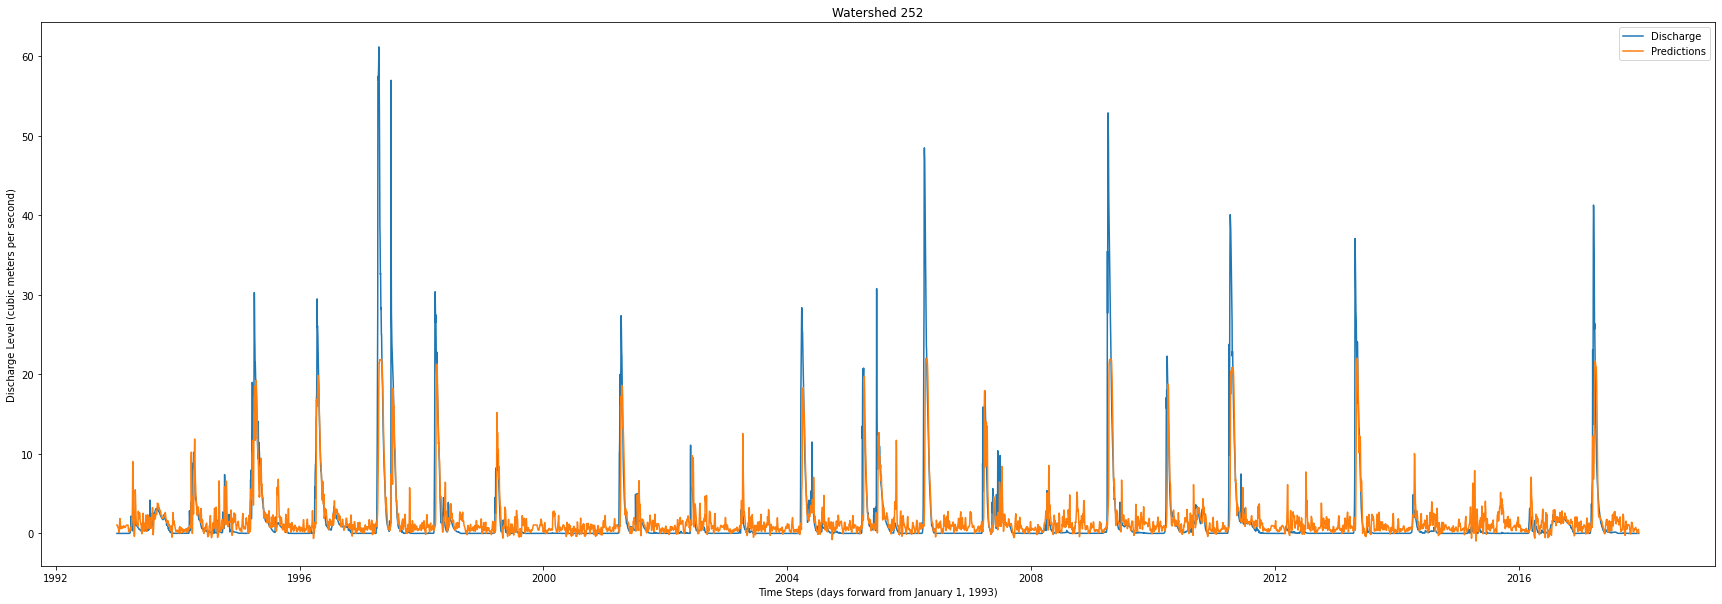

In [42]:
# For visual representation, plotting discharge of watershed 8

x = range(len(df_out))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 252")
plt.xlabel("Time Steps (days forward from January 1, 1993)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [43]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge_10[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 252, this model's sMAPE score is:", smape)

For Watershed 252, this model's sMAPE score is: 140.72380630027757


In [ ]:
# Plotting the loss scores, both training and test. 

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()